<a href="https://colab.research.google.com/github/maxboels/Predicting-Breast-Cancer-Malignancy-from-X-rays/blob/master/Thesis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Thesis/

/content/drive/My Drive/Colab Notebooks/Thesis


In [ ]:
ls

Data/                         Output/       Visualization/
import_data.py                __pycache__/  week_1_1.ipynb
my_model_weights_Epochs40.h5  thesis.ipynb  week1_2.ipynb
my_model_weights.h5           util.py       week1_2.py


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import util
import tifffile as tiff
import matplotlib.pyplot as plt
import cv2 
import os
from PIL import Image

from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

In [ ]:
## IMPORT DATA


# read filenames
train_list_files_benign, train_list_files_cancerous, test_list_files_benign, \
        test_list_files_cancerous = util.read_filenames()

#remarques: train_list_files_benign has 7 augmented files per raw file (7/8).
train_b = util.not_augmented_files(train_list_files_benign)

#remarques: train_list_files_cancerous has 1 augmented files per raw file (1/2).
train_c = util.not_augmented_files(train_list_files_cancerous)

#remarques: test_list_files_benign has 7 augmented files per raw file (7/8).
test_b = util.not_augmented_files(test_list_files_benign)

#remarques: test_list_files_cancerous has 1 augmented files per raw file (1/2).
test_c = util.not_augmented_files(test_list_files_cancerous)

# list o file list.
filelists = [train_b, train_c, test_b, test_c]

# create dataframes
df_trb, df_trc, df_tb, df_tc = util.create_dataframes(filelists, train_b, train_c, test_b, test_c)

# add dataset to dataframes
df_train, df_test = util.create_datasets(df_trb, df_trc, df_tb, df_tc)

# drop overlapping patients 
df_train = util.drop_overlapping_patients_train(df_train, df_test)

# insert images in train data frame
train_path = 'Data/raw train/'
test_path = 'Data/raw test/'

# add arrays
df_train = util.df_add_arrays(train_path, df_train)
df_test = util.df_add_arrays(test_path, df_test)

# rescale images to [0, 255] and save as png files
util.add_png_filenames(df_train)
util.add_png_filenames(df_test)

# create validation set with 50% of positives.
df_val, df_train = util.create_df_val(df_train)

We found and dropped 3 duplicated values in the data set which are:
                      images patient_id  array  malignancy
95   demd110692_CC_Right.tif     110692    NaN           1
473  demd110692_CC_Right.tif     110692    NaN           0
508  demd110692_CC_Right.tif     110692    NaN           1

Training and Testing DataFrame have been created.

These patients are in both the training and test datasets: ['1529']
There are 1 Patient IDs in both the training and test sets

We dropped overlapping patients ids from the training set patient:['1529']


In [ ]:
len(df_test)

129

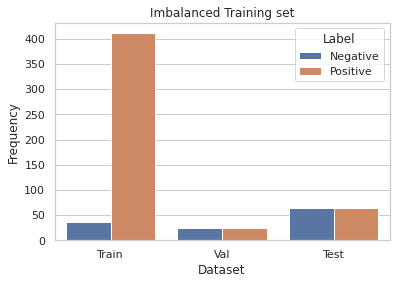

In [ ]:
## DATA VISUALIZATION


# # train 0 and 1
# util.show_png_images(df_train, 0, 'Data/out/train/')


## CLASS IMBALANCE


# WEIGHTED LOSS FUNCTION

# compute the class frequency
freq_pos_train, freq_neg_train = util.compute_label_freq(df_train)
freq_pos_val, freq_neg_val = util.compute_label_freq(df_val)
freq_pos_test, freq_neg_test = util.compute_label_freq(df_test)

# Visualization class frequency
sns.set(style="whitegrid")
data = pd.DataFrame({"Dataset": ['Train', 'Train', 'Val', 'Val', 'Test', 'Test'],
                     "Label": ['Negative','Positive','Negative','Positive','Negative','Positive'], 
                     "Frequency": [freq_neg_train, freq_pos_train,
                                    freq_neg_val, freq_pos_val,
                                    freq_neg_test, freq_pos_test]})
f = sns.barplot(x="Dataset", y="Frequency", hue="Label" ,data=data)
plt.title('Imbalanced Training set')



# calculate the positive weight as the fraction of negative labels
pos_weights = freq_neg_train
# calculate the negative weight as the fraction of positive labels
neg_weights = freq_pos_train

In [ ]:
'________METHOD 1:___________OVERSAMPLING______________________________________'

## OVERSAMPLING CLASS IMBALANCE
#df_train = util.oversampling(df_train)

'______METHOD 2 : WEIGHTED LOSS FUNCTION_______________________________'

# see util.py
'______METHOD 3:_____WEIGHTED CLASS______________________________________'

# get class weights for fit()
class_weight = util.get_class_weights(df_train)

Weight for class 0: 6.05
Weight for class 1: 0.55


In [ ]:
## DATA AUGMENTATION


from keras.preprocessing.image import ImageDataGenerator

'----------------------choose the pre-processing generator-------------------'

#from keras.applications.resnet50 import preprocess_input

from keras.applications.resnet_v2 import preprocess_input

#from keras.applications.densenet import preprocess_input

#from keras.applications.vgg19 import preprocess_input

In [ ]:
IMAGE_DIR = "Data/out/train/"
target_w = 320
target_h = 320
BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 5
BATCH_SIZE_TESTING = 1

'------------------------------TEST: Process_input from Imagenet Generator-------------------------'
data_generator = ImageDataGenerator(horizontal_flip = True,
                                    vertical_flip = True,
                                    preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_dataframe(
            dataframe=df_train,
            directory=IMAGE_DIR,
            x_col='images_png',
            y_col=['malignancy'],
            class_mode="raw",
            batch_size=BATCH_SIZE_TRAINING,
            shuffle=True,
            seed=1,
            target_size=(target_w,target_h))

valid_generator = data_generator.flow_from_dataframe(
        dataframe=df_val,
        directory= 'Data/out/validation/',
        x_col='images_png',
        y_col=['malignancy'],
        class_mode="raw",
        batch_size=BATCH_SIZE_VALIDATION,
        shuffle=False,
        seed=1,
        target_size=(target_w,target_h))

test_generator = data_generator.flow_from_dataframe(
        dataframe=df_test,
        directory='Data/out/test/',
        x_col='images_png',
        y_col=['malignancy'],
        class_mode="raw",
        batch_size=BATCH_SIZE_TESTING,
        shuffle=False,
        seed=1,
        target_size=(target_w,target_h))

Found 447 validated image filenames.
Found 49 validated image filenames.
Found 128 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="images_png". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


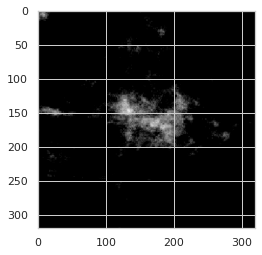

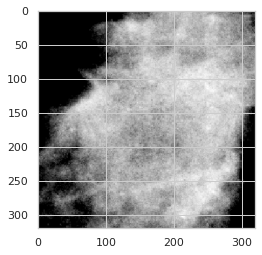

In [ ]:
# Note: the plotted image is not what the NN sees since imshow treats negative values
# as black pixels.
# plot train image in batch
plt.figure('training')
x_train, y_train = train_generator.__getitem__(0) 
plt.imshow(x_train[0])

# plot validation image in batch
plt.figure('validation')
x_valid, y_valid = valid_generator.__getitem__(0)
plt.imshow(x_valid[0])

In [ ]:

'____________________________CHOSE MODEL______________________________________'
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2


In [ ]:
from keras.applications.resnet_v2 import ResNet50V2


# path to weights without top layer
resnet_weights_path = 'Data/weights/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

# create the base pre-trained model
base_model = ResNet50V2(weights=resnet_weights_path, 
                      include_top=False)

# not training first layer model as it is already trained
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.1)(x)  # Regularize with dropout

# and a logistic layer
predictions = Dense(1, activation="sigmoid",
                    kernel_regularizer='l1')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

## COMPILE

LR = 0.0001 

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR)

# use custom weighted loss function or give class weigths in fit_generator
model.compile(optimizer= OPTIMIZER,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
## TRAINING

EPOCHS = 40
PATIENCE = 40

STEPS_PER_EPOCH_TRAINING = len(train_generator)
STEPS_PER_EPOCH_VALIDATION = len(valid_generator)
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)

# the data is augmented accordingly to the number of batches as argument
history_0001_l1 = model.fit(train_generator, 
                    validation_data= valid_generator,
                    steps_per_epoch=STEPS_PER_EPOCH_TRAINING, # batches
                    validation_steps=STEPS_PER_EPOCH_VALIDATION,# batches
                    epochs = EPOCHS,
                    callbacks= [early_stopping],
                    class_weight= class_weight)


Epoch 1/40
45/45 [==============================] - 4s 87ms/step - loss: 1.3502 - accuracy: 0.3512 - val_loss: 1.3025 - val_accuracy: 0.3673
Epoch 2/40
45/45 [==============================] - 3s 72ms/step - loss: 1.2740 - accuracy: 0.3602 - val_loss: 1.2368 - val_accuracy: 0.3469
Epoch 3/40
45/45 [==============================] - 3s 73ms/step - loss: 1.2041 - accuracy: 0.4385 - val_loss: 1.1902 - val_accuracy: 0.4286
Epoch 4/40
45/45 [==============================] - 3s 73ms/step - loss: 1.1874 - accuracy: 0.4139 - val_loss: 1.1269 - val_accuracy: 0.5102
Epoch 5/40
45/45 [==============================] - 3s 74ms/step - loss: 1.1429 - accuracy: 0.3893 - val_loss: 1.0900 - val_accuracy: 0.4694
Epoch 6/40
45/45 [==============================] - 3s 73ms/step - loss: 1.0657 - accuracy: 0.4004 - val_loss: 1.0729 - val_accuracy: 0.4490
Epoch 7/40
45/45 [==============================] - 3s 72ms/step - loss: 1.0502 - accuracy: 0.4385 - val_loss: 1.0257 - val_accuracy: 0.5306
Epoch 8/40
45

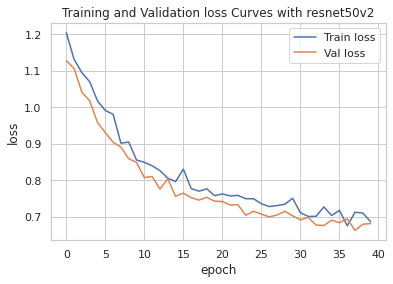

In [ ]:

# Loss plot
plt.plot(history_0001_l1.history['loss'])
plt.plot(history_0001_l1.history['val_loss'])

plt.legend(['Train loss',
            'Val loss'], loc='upper right')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training and Validation loss Curves with "+ base_model.name)
plt.show()



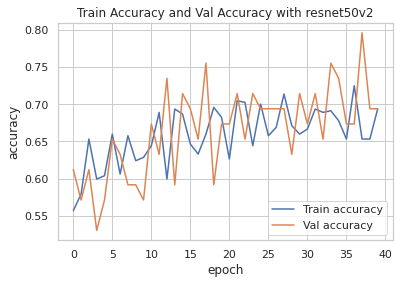

In [ ]:
# Accuracy plot
plt.plot(history_0001_l1.history['accuracy'])
plt.plot(history_0001_l1.history['val_accuracy'])
plt.legend(['Train accuracy', 'Val accuracy'], loc='lower right')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Train Accuracy and Val Accuracy with "+ base_model.name)
plt.show()

In [ ]:
model.save_weights('my_model_weights_Epochs40.h5')

In [ ]:
## PREDICTION AND EVALUATION ON TEST SET

# predict
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
print(f' std: {predicted_vals.std()}\n min: {predicted_vals.min()}\n max: {predicted_vals.max()}')

 std: 0.10920363664627075
 min: 0.17281460762023926
 max: 0.7888340353965759


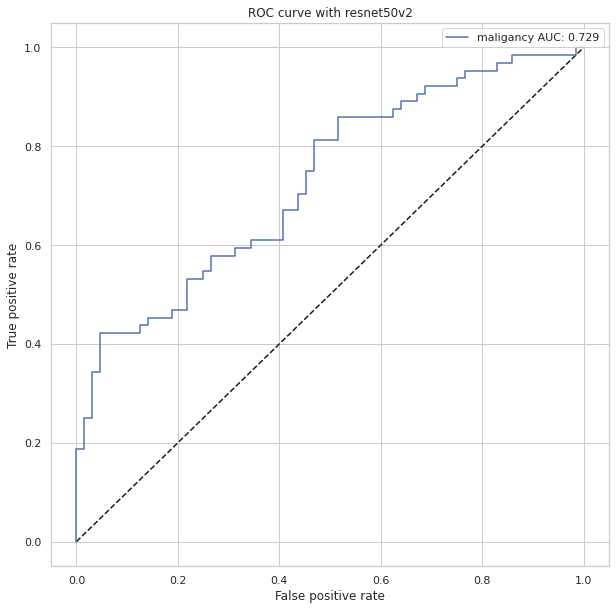

In [ ]:
#ROC and AUROC
labels = ['maligancy']
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator, base_model)
